This is an implementation of a Seq2Seq model for generating song titles. The model consists of an Encoder and a Decoder.

The Encoder takes in the input text (song lyrics) and converts it into a fixed-length vector representation. It does this by first converting each word in the input text into a high-dimensional vector using an embedding layer. The LSTM layer then processes these vectors sequentially and outputs a final hidden state and cell state, which represent the encoded representation of the input text.

The Decoder takes in the encoded representation, and generates the output text (song titles) word-by-word. It does this by using the encoded representation as the initial hidden state and cell state, and then predicting the next word in the output text using an LSTM layer and a linear layer. The predicted word is then fed back into the LSTM layer to generate the next word, and so on until the entire output text has been generated.

The Seq2Seq model as a whole is trained using a teacher forcing approach, where during training, the true output sequence is used as the input to the Decoder at each time step. During inference (i.e., when generating song titles), the model uses its own predicted output sequence as the input to the Decoder at each time step.

Overall, this model can be used to generate song titles given a set of song lyrics as input.

### Download the dataset from Kaggle

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload() # Upload kaggle.json as described in the link
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d terminate9298/songs-lyrics
! unzip -q songs-lyrics.zip -d data

Saving kaggle.json to kaggle.json
 41% 5.00M/12.1M [00:00<00:00, 37.1MB/s]
100% 12.1M/12.1M [00:00<00:00, 66.0MB/s]


### Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import random


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Load the dataset

In [3]:
# Load the lyrics dataset
lyrics_df = pd.read_csv('data/lyrics.csv')
# Load the songs details dataset
songs_df = pd.read_csv('data/songs_details.csv')


# Merge the two datasets on the 'song_name' column
df = pd.merge(lyrics_df, songs_df, on='song_name')

# Drop unnecessary columns
df = df.drop(['link', 'song_id', 'singer_name', 'song_href'], axis=1)

# Drop rows with missing values or empty strings
df = df.dropna()
df = df[df['lyrics'] != '']


song_lyrics = lyrics_df['lyrics'].tolist()
song_titles = songs_df['song_name'].tolist()[0:len(song_lyrics)]

tokenizer = get_tokenizer('basic_english')

def tokenize_and_pad(arr, max_len=100):
    tokenized = [tokenizer(text)[:max_len] for text in arr]
    padded = []
    for tokens in tokenized:
        padded.append(tokens + ['<pad>'] * (max_len - len(tokens)))
    return padded

song_lyrics_tokenized = tokenize_and_pad(song_lyrics)
song_titles_tokenized = tokenize_and_pad(song_titles)

vocab = build_vocab_from_iterator(song_lyrics_tokenized + song_titles_tokenized, min_freq=2, specials=['<unk>', '<sos>', '<eos>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])

stoi = vocab.get_stoi()
itos = vocab.get_itos()

def tokens_to_indices(arr):
    return [[stoi.get(token, stoi['<unk>']) for token in tokens] for tokens in arr]


song_lyrics_indices = tokens_to_indices(song_lyrics_tokenized)
song_titles_indices = tokens_to_indices(song_titles_tokenized)

train_lyrics, test_lyrics, train_titles, test_titles = train_test_split(song_lyrics_indices, song_titles_indices, test_size=0.2, random_state=42)


class SongDataset(Dataset):
    def __init__(self, song_lyrics, song_titles):
        self.song_lyrics = song_lyrics
        self.song_titles = song_titles

    def __len__(self):
        return len(self.song_lyrics)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return {'song_lyric': torch.tensor(self.song_lyrics[idx]), 'song_title': torch.tensor(self.song_titles[idx])}

train_dataset = SongDataset(train_lyrics, train_titles)
test_dataset = SongDataset(test_lyrics, test_titles)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0)


### Model without attention

In [4]:
class EncoderWithout(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(EncoderWithout, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout_rate, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(x)
        return hidden, cell


class DecoderWithout(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(DecoderWithout, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        x = self.embedding(x)
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        predictions = self.fc(output)
        predictions = predictions.squeeze(1)
        return predictions, hidden, cell


class Seq2SeqWithout(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2SeqWithout, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, encoder_outputs, teacher_force_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = len(vocab)

        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)

        hidden, cell = self.encoder(source)

        x = target[:, 0]

        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_force_ratio
            best_guess = output.argmax(1)
            x = target[:, t] if teacher_force else best_guess

        return outputs




### Model with attention

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout_rate, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(x)
        return outputs, hidden, cell


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.W1 = nn.Linear(hidden_size, hidden_size)
        self.W2 = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden[-1].unsqueeze(1)
        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))
        attention = F.softmax(self.V(energy), dim=1)
        context = torch.sum(attention * encoder_outputs, dim=1)
        return context, attention


class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, num_layers, dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, cell, encoder_outputs):
        x = x.unsqueeze(1)
        x = self.embedding(x)

        context, attention_weights = self.attention(hidden, encoder_outputs)
        context = context.unsqueeze(1)
        x = torch.cat((x, context), dim=2)

        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        predictions = self.fc(output)
        predictions = predictions.squeeze(1)

        return predictions, hidden, cell, attention_weights

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = len(vocab)

        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)

        encoder_outputs, hidden, cell = self.encoder(source)

        x = target[:, 0]

        for t in range(1, target_len):
            output, hidden, cell, attention_weights = self.decoder(x, hidden, cell, encoder_outputs)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_force_ratio
            best_guess = output.argmax(1)
            x = target[:, t] if teacher_force else best_guess

        return outputs



### Initialize the models

In [6]:
input_size_without = len(vocab)
hidden_size_without = 512
num_layers_without = 2
dropout_rate_without = 0.5

encoder_without = EncoderWithout(input_size_without, hidden_size_without, num_layers_without, dropout_rate_without).to(device)
decoder_without = DecoderWithout(input_size_without, hidden_size_without, num_layers_without, dropout_rate_without).to(device)

model_without = Seq2SeqWithout(encoder_without, decoder_without).to(device)

epochs_without = 10
lr_without = 0.001
clip_without = 1

criterion_without = nn.CrossEntropyLoss(ignore_index=vocab.get_stoi()['<pad>'])
optimizer_without = optim.Adam(model_without.parameters(), lr=lr_without)




input_size = len(vocab)
hidden_size = 128
num_layers = 2
dropout_rate = 0.5

encoder = Encoder(input_size, hidden_size, num_layers, dropout_rate).to(device)
decoder = Decoder(input_size, hidden_size, num_layers, dropout_rate).to(device)
model = Seq2Seq(encoder, decoder).to(device)

epochs = 20
lr = 0.001
clip = 1

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.get_stoi()['<pad>'])


### Training and Evaluation

In [7]:
def train(model, dataloader, optimizer, criterion, clip):
    model.train()

    epoch_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()

        song_lyric = batch['song_lyric'].to(device)
        song_title = batch['song_title'].to(device)

        output = model(song_lyric, song_title)
        output = output[:, 1:].reshape(-1, output.shape[2])
        song_title = song_title[:, 1:].reshape(-1)


        loss = criterion(output, song_title)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


def evaluate(model, dataloader, criterion):
    model.eval()

    epoch_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            song_lyric = batch['song_lyric'].to(device)
            song_title = batch['song_title'].to(device)

            output = model(song_lyric, song_title)
            output = output[:, 1:].reshape(-1, output.shape[2])
            song_title = song_title[:, 1:].reshape(-1)

            loss = criterion(output, song_title)
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


def train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, criterion, epochs, clip, name=''):

    training_losses = []
    validation_losses = []
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        train_loss = train(model, train_dataloader, optimizer, criterion, clip)
        valid_loss = evaluate(model, test_dataloader, criterion)

        training_losses.append(train_loss)
        validation_losses.append(valid_loss)

    plt.plot(training_losses, label='training loss')
    plt.plot(validation_losses, label='validation loss')
    plt.legend()
    plt.title(f'seq2seq_songtitles{"_" + name}')
    plt.show()


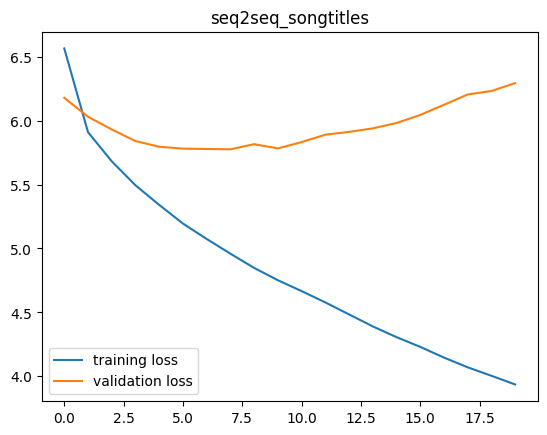

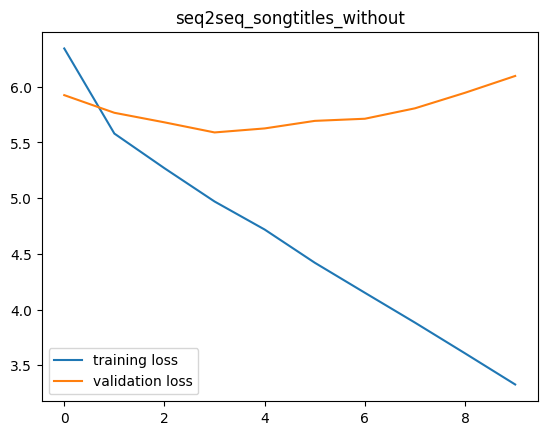

In [27]:
train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, criterion, epochs, clip)
train_and_evaluate(model_without, train_dataloader, test_dataloader, optimizer_without, criterion_without, epochs_without, clip_without, 'without')

### The cells below use Beam-Search to generate a song title

Model with Attention

In [11]:
from heapq import nlargest

def beam_search(model, lyrics, max_length=100, beam_width=5):
    model.eval()

    lyrics_tokens = tokenizer(lyrics.lower())
    lyrics_indices = tokens_to_indices([lyrics_tokens])[0]
    lyrics_tensor = torch.LongTensor(lyrics_indices).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(lyrics_tensor)

    sequences = [([], 0, hidden, cell)]

    for _ in range(max_length):
        new_sequences = []

        for seq, score, hidden, cell in sequences:
            x = torch.tensor([seq[-1] if seq else vocab.get_stoi()['<sos>']]).to(device)

            with torch.no_grad():
                output, hidden, cell, attention_weights = model.decoder(x, hidden, cell, encoder_outputs)

            output = F.log_softmax(output, dim=1).squeeze(0)

            topk_scores, topk_indices = output.topk(beam_width, dim=-1)

            for index, token_score in enumerate(topk_scores):
                token_idx = topk_indices[index].item()
                new_seq = seq + [token_idx]
                new_score = score + token_score.item()
                new_hidden = hidden.clone().detach()
                new_cell = cell.clone().detach()

                if token_idx == vocab.get_stoi()['<eos>']:
                    return new_seq

                new_sequences.append((new_seq, new_score, new_hidden, new_cell))

        sequences = nlargest(beam_width, new_sequences, key=lambda x: x[1])

    best_sequence = max(sequences, key=lambda x: x[1])[0]
    return best_sequence

def generate_title_beam_search(model, lyrics, max_length=100, beam_width=5):
    generated_title_indices = beam_search(model, lyrics, max_length, beam_width)
    generated_title_tokens = [vocab.get_itos()[idx] for idx in generated_title_indices]
    title_string = ' '.join(token for token in generated_title_tokens if token not in ['<unk>', '<sos>', '<eos>', '<pad>', '(', ')', "'"])
    return title_string



In [37]:
indices = np.random.randint(0, len(test_dataset), 30)
for i in indices:
    lyrics = test_dataset[i]['song_lyric']
    title = test_dataset[i]['song_title']
    lyrics = ' '.join([vocab.get_itos()[idx] for idx in lyrics])
    title = ' '.join([vocab.get_itos()[idx] for idx in title if idx != 3])
    generated_title = generate_title_beam_search(model, lyrics)
    print(f"Lyrics: {lyrics}")
    print(f"Original title: {title}")
    print(f"Generated title: {generated_title}")
    print()

Lyrics: ah the star out tonight i don ' t know if it ' s cloudy or bright ' cause i only have eyes for you dear the moon may be high but i can ' t see a thing in the sky ' cause i only have eyes for you i don ' t know if we ' re in a garden or on a crowded avenue you are here so am i maybe millions of people go by but they all disappear from view and i only have eyes . . . . . <pad> <pad> <pad> <pad> <pad>
Original title: maneater
Generated title: cold outside

Lyrics: and i love you so , the people ask me how , how i ' ve lived till now i tell them i don ' t know i guess they understand how lonely life has been but life began again the day you took my hand and yes i know how lonely life can be shadows follow me the night won ' t set me free but i don ' t let the evening get me down now that you ' re around me and you love me too your thoughts are just for me you set my spirit free
Original title: kriss kross
Generated title: if i m gone home remix

Lyrics: i ain ' t tellin no jokes my

Model without Attention

In [23]:
def update_beam_and_finished(beam_candidates, finished_candidates, eos_token):
    new_beam = []
    for candidate in beam_candidates:
        if candidate[0][-1] == eos_token:
            finished_candidates.append(candidate)
        else:
            new_beam.append(candidate)
    return new_beam, finished_candidates

def generate_title_without(model, input_lyric, max_length=100, beam_size=5):
    model.eval()

    input_indices = tokens_to_indices(tokenize_and_pad([input_lyric], max_length))
    input_tensor = torch.tensor(input_indices).to(device)

    hidden, cell = model.encoder(input_tensor)

    beam_candidates = [([vocab['<sos>']], 0, hidden, cell)]
    finished_candidates = []

    for _ in range(max_length):
        new_candidates = []

        for candidate in beam_candidates:
            seq, score, hidden, cell = candidate
            prev_word = torch.tensor([seq[-1]]).to(device)

            with torch.no_grad():
                output, hidden, cell = model.decoder(prev_word, hidden, cell)
                output = F.log_softmax(output, dim=1)
            
            topk_output, topk_indices = output.topk(beam_size, 1)

            for i in range(beam_size):
                new_seq = seq + [topk_indices[0][i].item()]
                new_score = score + topk_output[0][i].item()
                new_candidate = (new_seq, new_score, hidden, cell)
                new_candidates.append(new_candidate)

        beam_candidates = sorted(new_candidates, key=lambda x: x[1], reverse=True)[:beam_size]
        beam_candidates, finished_candidates = update_beam_and_finished(beam_candidates, finished_candidates, vocab['<eos>'])

    if finished_candidates:
        best_candidate = sorted(finished_candidates, key=lambda x: x[1], reverse=True)[0]
    else:
        best_candidate = sorted(beam_candidates, key=lambda x: x[1], reverse=True)[0]

    decoded_title = [itos[idx] for idx in best_candidate[0][1:]]
    title = ' '.join(token for token in decoded_title if token not in ['<unk>', '<sos>', '<eos>', '<pad>', '(', ')', "'"])

    return title



In [36]:
indices = np.random.randint(0, len(test_dataset), 5)
for i in indices:
    lyrics = test_dataset[i]['song_lyric']
    title = test_dataset[i]['song_title']
    lyrics = ' '.join([vocab.get_itos()[idx] for idx in lyrics])
    title = ' '.join([vocab.get_itos()[idx] for idx in title if idx != 3])
    generated_title = generate_title_without(model_without, lyrics)
    print(f"Lyrics: {lyrics}")
    print(f"Original title: {title}")
    print(f"Generated title: {generated_title}")
    print()

Lyrics: how come the best ones are always taken what i see when i see ya - is love in the makin ' something about timin ' , something about fate gotta go with the feeling - not a moment too waste bring it on bring it on <unk> - i was born ready i ' m a son of a strong man - i ' m rock steady everything you throw - i can see it coming ain ' t gonna be no tko just a lot of lovin ' cuz opposites attract this way if day is night and
Original title: how many birds
Generated title: in the mirror remix

Lyrics: i just bought a new watch i think they on to us i got four or five spots i think they on to us all we drive is foreign cars i think they on to us every time i ' m in the club i ' m with a foreign brand i swear they on to us ap or frank <unk> i got choices i ' m in the car by myself i ' m hearing voices lamborghini , bentley coupe , bentley , rolls royces gotta the way entourage attracts the task forces hand the kush out the dj
Original title: feed tha streets
Generated title: around th